绘制照片每月的评分变化曲线。
照片评分的假定：
1. 每个月照片质量的分布服从同一个正态分布
2. 在不考虑赞和踩的情况下，照片质量与浏览次数有关。同一个月的照片，浏览次数越高，质量越高。但不同月份的两张照片不可直接通过浏览次数进行比较。
3. 考虑赞和踩的情况，认为赞对评分有正向的激励，踩对评分有负向的激励。且踩比赞的权重大。
4. 马太效应：浏览次数高的照片，更容易获得点击。

先考虑同一个月的照片的评分和比较。
根据假定2和4，照片的评分应该正比于其浏览次数的对数（想象一个坐标系，横轴是照片的质量，纵轴是照片的浏览次数的对数。）。
根据假定3，我们引入经验性公式：$$score \propto \log(click \times \frac{\lambda \cdot zan + 1}{cai + 1}+1)$$
其中$\lambda$是权重，默认为$0.05$。意味着$20$个赞$0$个踩可以使照片的评分+1；而一个踩就可以让照片的评分-1。

最后，根据假设1，我们考虑不同月份之间照片的比较。
由于假定了每个月照片质量服从同一正态分布，我们可以将上式给出的评分归一化到标准正态分布下（均值为0，方差为1），就可以进行不同月份之间score的比较了。

对于同月份的照片，这个归一化过程是保序的。


<Container object of 3 artists>

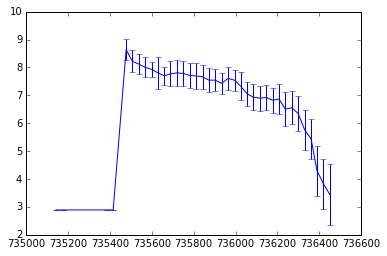

In [1]:
# 每月的平均评分（未归一化）随时间的变化
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from datetime import datetime

def get_score(zan_num, cai_num, show, hotness, day):
    LAMBDA = 0.05
    return np.log(show*(zan_num*LAMBDA+1)/(cai_num+1)+1)
    
    #LAMBDA = 10
    #return np.log(show*(zan_num+LAMBDA)*1.0/(cai_num+LAMBDA)+1.0)
    
    #LAMBDA = 2
    #log_show = np.log(show+1)
    #weight = np.log2((zan_num+LAMBDA)*1.0/(cai_num+LAMBDA)+1)
    #return log_show*weight

img_score_dict = {}
with open("./data/img_attr.csv", 'r') as fin:
    for line in fin:
        attrs = line.strip().split("\t")
        if len(attrs) != 7:
            continue
        imgid, zan_num, cai_num, show, hotness, date, title = attrs
        if date == "NAN":
            continue
        key = datetime.strptime(date[:7],'%Y/%m')
        img_score_dict.setdefault(key, [])
        img_score_dict[key].append((int(imgid), get_score(int(zan_num), int(cai_num), int(show), float(hotness), int(date[-2:]))))

mean_by_month = []
std_by_month = []
month = []
for date, img_scores in sorted(img_score_dict.items(), key=lambda x: x[0]):
    img_scores = np.array(img_scores)
    
    mean_score = np.mean(img_scores[:,1])
    std_score = np.std(img_scores[:,1])
    
    month.append(date)
    mean_by_month.append(mean_score)
    std_by_month.append(std_score)
    
x = date2num(month)
#plt.plot_date(x, np.array(mean_by_month), fmt="-o")
plt.errorbar(x, np.array(mean_by_month), yerr=np.array(std_by_month))
#print zip(month, mean_by_month)
    

<Container object of 3 artists>

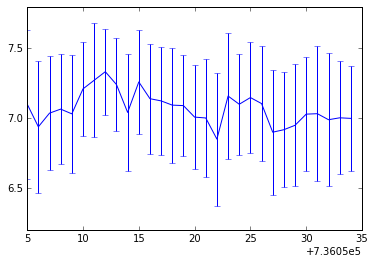

In [2]:
# 每天的平均评分（未归一化）随时间的变化
img_score_dict = {}
with open("./data/img_attr.csv", 'r') as fin:
    for line in fin:
        attrs = line.strip().split("\t")
        if len(attrs) != 7:
            continue
        imgid, zan_num, cai_num, show, hotness, date, title = attrs
        if not date.startswith("2016/04"):
            continue
        key = datetime.strptime(date,'%Y/%m/%d')
        img_score_dict.setdefault(key, [])
        img_score_dict[key].append((int(imgid), get_score(int(zan_num), int(cai_num), int(show), float(hotness), int(date[-2:]))))

mean_by_day = []
std_by_day = []
days = []
for date, img_scores in sorted(img_score_dict.items(), key=lambda x: x[0]):
    img_scores = np.array(img_scores)
    
    mean_score = np.mean(img_scores[:,1])
    std_score = np.std(img_scores[:,1])
    
    days.append(date)
    mean_by_day.append(mean_score)
    std_by_day.append(std_score)
    
x = date2num(days)
#plt.plot_date(x, np.array(mean_by_month), fmt="-o")
plt.errorbar(x, np.array(mean_by_day), yerr=np.array(std_by_day))
#print zip(month, mean_by_month)

读取某个月的数据，对点击次数取log后高斯归一，绘出分布曲线

mean: 2.57637492948e-17
media: -0.0431850604164
std: 1.0


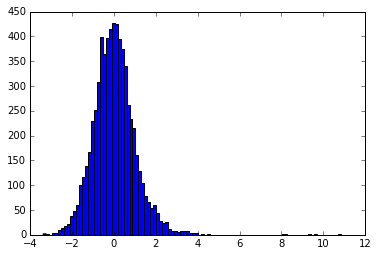

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

date_pattern = "2016/10"
img_pool = []
with open("./data/img_attr.csv", 'r') as fin:
    for line in fin:
        attrs = line.strip().split("\t")
        if len(attrs) != 7:
            continue
        imgid, zan_num, cai_num, show, hotness, date, title = attrs
        if date.startswith(date_pattern):
            img_pool.append((int(imgid), get_score(int(zan_num), int(cai_num), int(show), float(hotness), int(date[-2:]))))

img_matrix = np.array(img_pool)

# 标准化后的score
score = img_matrix[:,1]
mean_score = np.mean(score)
std_score = np.std(score)
normalized_score = (score - mean_score) / std_score
#normalized_score[normalized_score>5] = 5.0
#normalized_score[normalized_score<-3] = -3.0

print "mean: %s"%np.mean(normalized_score)
print "media: %s"%np.median(normalized_score)
print "std: %s"%np.std(normalized_score)

plt.hist(normalized_score, 100)
plt.show()

展示几张不同score

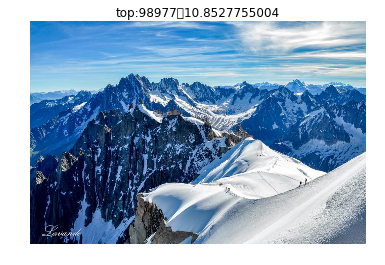

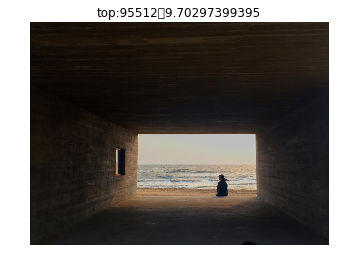

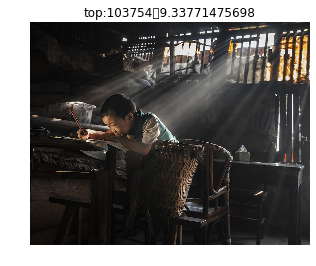

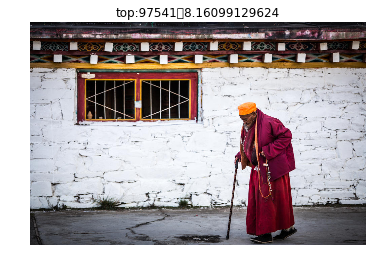

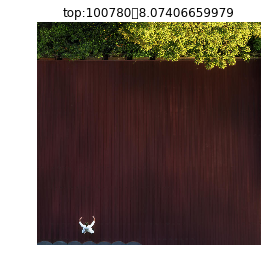

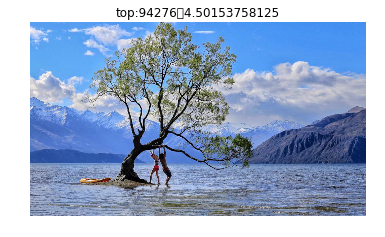

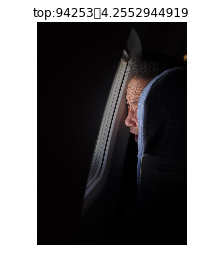

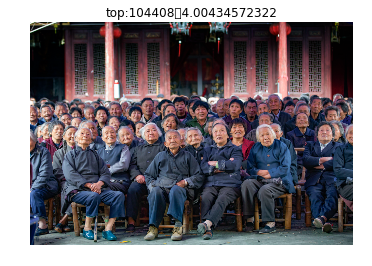

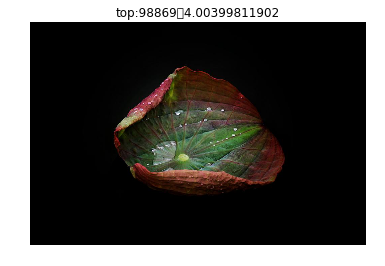

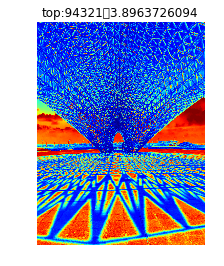

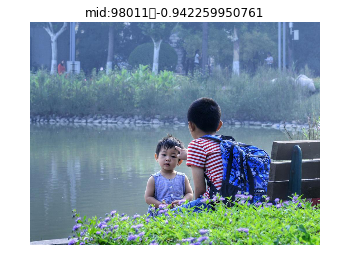

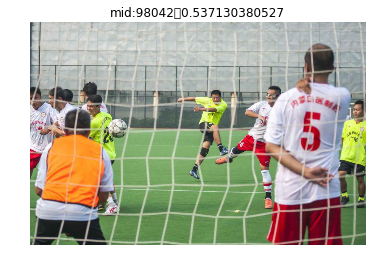

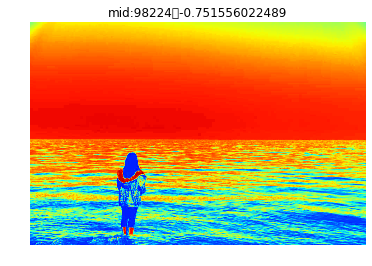

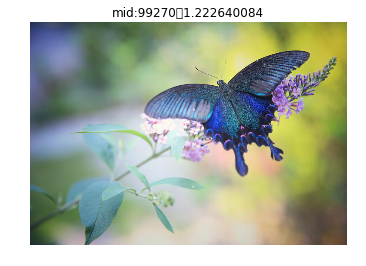

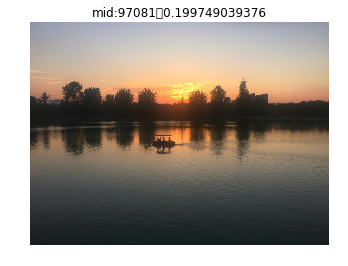

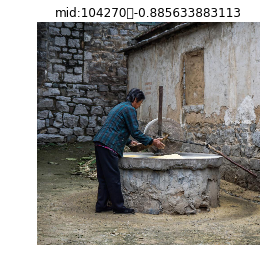

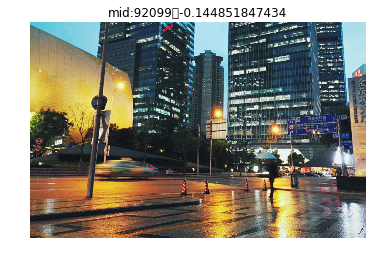

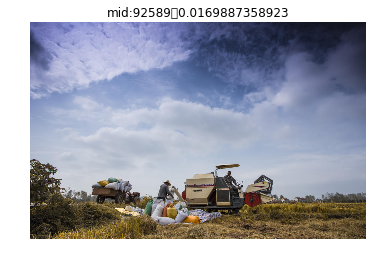

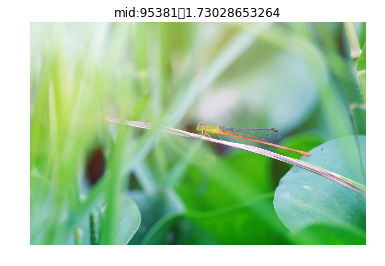

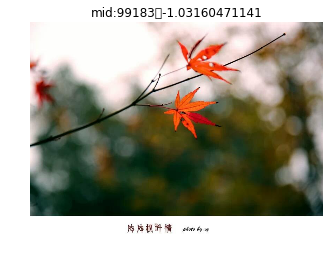

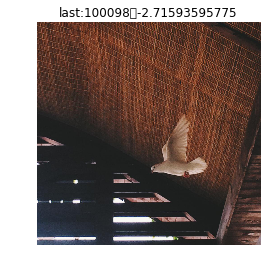

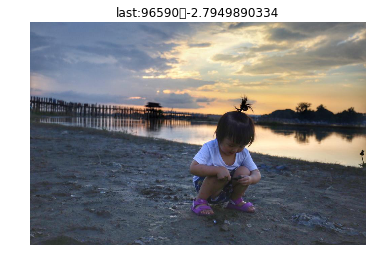

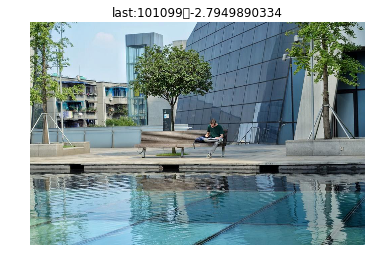

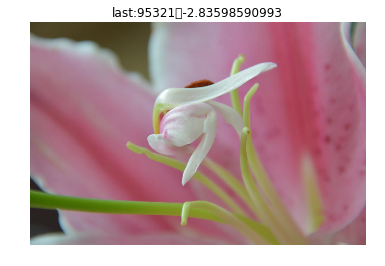

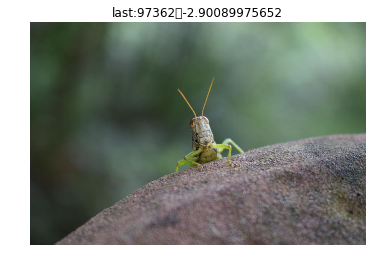

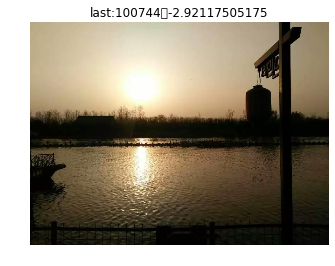

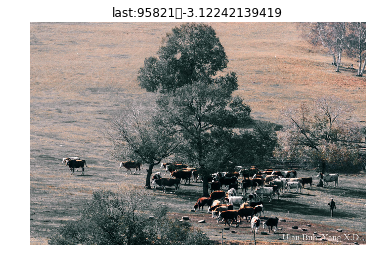

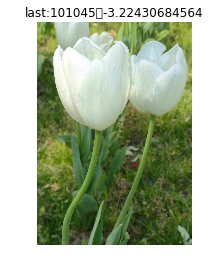

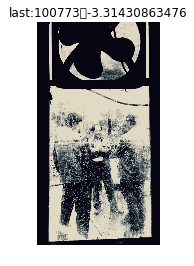

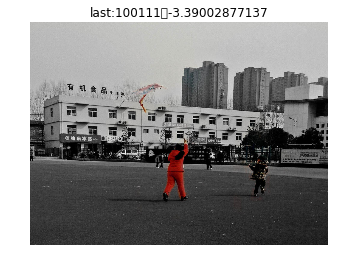

In [6]:
%matplotlib inline
def plot(imgid, title=""):
    if type(imgid) != str:
        imgid = str(int(imgid))
    img_file = "./data/img/%s.jpg"%imgid
    img = Image.open(img_file)
    plt.figure()
    plt.axis('off')
    plt.title(title)
    plt.imshow(img)
    plt.show()

#img_matrix = np.array(img_pool)
#max_show = img_matrix[:,1].max()
#min_show = img_matrix[:,1].min()
#normalized_score = (img_matrix[:,1]-min_show)*1.0/(max_show-min_show)

K = 10
sorted_idx = normalized_score.argsort()[::-1]
topK_idx = sorted_idx[:K]
mid_idx = np.random.permutation(sorted_idx)[:K]
lastK_idx = sorted_idx[-K:]

for imgid, z_score in zip(img_matrix[topK_idx,0], normalized_score[topK_idx]):
    imgid = int(imgid)
    plot(imgid, title="top:"+str(imgid)+"\t"+str(z_score))
    
for imgid, z_score in zip(img_matrix[mid_idx,0], normalized_score[mid_idx]):
    imgid = int(imgid)
    plot(imgid, title="mid:"+str(imgid)+"\t"+str(z_score))
    
for imgid, z_score in zip(img_matrix[lastK_idx,0], normalized_score[lastK_idx]):
    imgid = int(imgid)
    plot(imgid, title="last:"+str(imgid)+"\t"+str(z_score))